# IMDB review Word2Vec & BiLSTM

[kaggle notebook link](https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc)

<br>

# 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import tqdm

import os
for file in os.listdir("../../input") :
    print(file)

Using TensorFlow backend.


labeledTrainData.tsv
sampleSubmission.csv
testData.tsv
unlabeledTrainData.tsv


<br>

# 2. Set some matplotlib configs for visualization

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}

plt.rcParams.update(params)

<br>

# 3. Import data

Importing the existing datasets and also import the IMDB dataset from another source. It helps us to increase maximal accuracy of our model from ~87% to 90+%.

In [3]:
usecols = ['sentiment', 'review']

notebook_pos = "local" # kaggle

train_data = pd.DataFrame()
additional_data = pd.DataFrame()


if notebook_pos == "local" :
    
    train_data = pd.read_csv(filepath_or_buffer='../../input/labeledTrainData.tsv',
                             usecols=usecols,
                             sep='\t')
    #additional_data = pd.read_csv(filepath_or_buffer='../../input/imdb_master_filtered.csv',
    #                              sep='\t')[usecols]
    unlabeled_data = pd.read_csv(filepath_or_buffer='../../input/unlabeledTrainData.tsv',
                                 error_bad_lines=False,
                                 sep='\t')
    submission_data = pd.read_csv(filepath_or_buffer='../../input/testData.tsv',
                                  sep='\t')
    
else :
    
    train_data = pd.read_csv(filepath_or_buffer='../input/word2vec-nlp-tutorial/labeledTrainData.tsv',
                             usecols=usecols, 
                             sep='\t')
    #additional_data = pd.read_csv(filepath_or_buffer='../input/imdb-review-dataset/imdb_master_filtered.csv',
    #                              sep='\t')[usecols]
    unlabeled_data = pd.read_csv(filepath_or_buffer="../input/word2vec-nlp-tutorial/unlabeledTrainData.tsv", 
                                 error_bad_lines=False,
                                 sep='\t')
    submission_data = pd.read_csv(filepath_or_buffer="../input/word2vec-nlp-tutorial/testData.tsv",
                                  sep='\t')

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [4]:
#datasets = [train_data, additional_data, submission_data, unlabeled_data]
datasets = [train_data, submission_data, unlabeled_data] # additional_data
#titles = ['Train data', 'Additional data', 'Unlabeled train data', 'Submission data']
titles = ['Train data', 'Unlabeled train data', 'Submission data'] # 'Additional data'

for dataset, title in zip(datasets, titles) :
    print(title)
    dataset.info()
    display(dataset.head())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


Unlabeled train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.8+ KB


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


Submission data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
id        49998 non-null object
review    49998 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [5]:
all_reviews = np.array([], dtype=str)

for dataset in datasets :
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
    
print('Total number of reviews: ', len(all_reviews))

Total number of reviews:  99998


In [6]:
#train_data = pd.concat((train_data, additional_data[additional_data.sentiment != -1]), axis=0, ignore_index=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


<br>

# 4. Check class balance

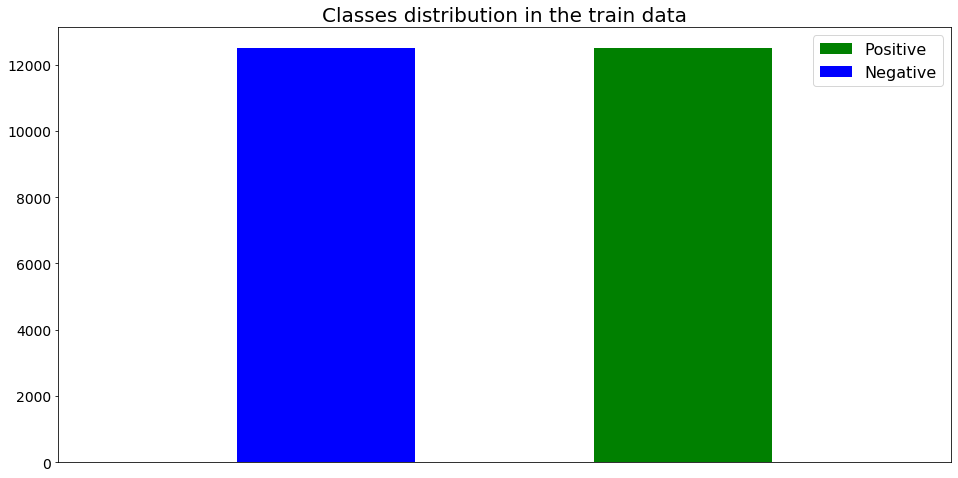

In [7]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2,
         color='green',
         label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2,
         color='blue',
         label='Negative')
plt.title('Classes distribution in the train data',
          fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [8]:
def clean_review(raw_review: str) -> str :
    
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, 'lxml').get_text()
    
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    
    return lowercase_letters

def lemmatize(tokens: list) -> list :
    
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x : lemmatizer.lemmatize(x, "v"), tokens))
    
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    
    return meaningful_words

def preprocess(review: str, total: int, show_progress: bool = True) -> list :
    
    if show_progress :
        global counter
        counter += 1
        print('Processing... %6i/%6i'%(counter, total), end='\r')
        
    # 1. Clean text
    review = clean_review(review)
    
    # 2. Split into individual words
    tokens = word_tokenize(review)
    
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    
    # 4. Join the words back into one string separated by space,
    # and return the result
    return lemmas

In [9]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
all_reviews = np.array(list(map(lambda x : preprocess(x, len(all_reviews), False), all_reviews)))
counter = 0

In [14]:
all_reviews[125000: 150000]

array([], dtype=object)

In [ ]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission